# Modélisation

## Premier modèle de classification


### Setup du notebook et chargement des données


In [1]:
import pandas as pd
import preprocessing as pp
import modelization as md
import visualizer as vi
import matplotlib.pyplot as plt

#Selection
from sklearn.model_selection import (
	train_test_split,
	StratifiedKFold
)
#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score



df = pd.read_csv("data/data_clean.csv")

TARGET = 'a_quitte_l_entreprise'
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLIT = 5

X, y, preprocessor = pp.prepare_ml_data(df, TARGET)

### Inspection des données d'entrée

Avant de modéliser, vérifions la structure des données préparées à l'étape 2 : dimensions de X et y, types de features détectés par le preprocessor, et aperçu des premières lignes.

In [2]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Dimensions : X = {X.shape}, y = {y.shape}")
print(f"\nFeatures numériques ({len(numeric_features)}) : {numeric_features}")
print(f"\nFeatures catégorielles ({len(categorical_features)}) : {categorical_features}")
print(f"\nDistribution de la cible :")
print(y.value_counts().rename(index={0: 'Reste', 1: 'Quitte'}))

display(X.head())

Dimensions : X = (1470, 28), y = (1470,)

Features numériques (24) : ['age', 'genre', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'frequence_deplacement', 'mobilite_interne', 'age_debut_carriere', 'stabilite_management', 'score_satisfaction_global', 'engagement_formation']

Features catégorielles (4) : ['statut_marital', 'departement', 'poste', 'domaine_etude']

Distribution de la cible :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64


/tmp/ipykernel_60058/244927319.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,satisfaction_employee_environnement,...,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,frequence_deplacement,mobilite_interne,age_debut_carriere,stabilite_management,score_satisfaction_global,engagement_formation
0,41,0,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,2,...,0,1,2,Infra & Cloud,1,2,33,1.000000,2.00,0.000000
1,49,1,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,3,...,3,8,1,Infra & Cloud,2,3,39,0.875000,3.00,0.272727
2,37,1,2090,Célibataire,Consulting,Consultant,6,7,0,4,...,3,2,2,Autre,1,0,30,0.000000,3.00,3.000000
3,33,0,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,4,...,3,3,4,Infra & Cloud,2,1,25,0.000000,3.25,0.333333
4,27,1,3468,Marié(e),Consulting,Consultant,9,6,2,1,...,3,2,1,Transformation Digitale,1,0,21,0.666667,2.50,1.000000


### Séparation train/test

Le découpage train/test est réalisé avec l’option `stratify=y` afin de préserver la distribution des classes dans les deux ensembles, ce qui est essentiel compte tenu du fort déséquilibre du jeu de données, et permet d’obtenir une évaluation plus représentative des performances du modèle.

Nous réservons 20% des données comme jeu de test pour l'évaluation finale des modèles, et nous appliquerons une validation croisée sur le jeu de train.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
	stratify=y
)

### Distribution des classes

Avant d'entraîner nos modèles, il est essentiel de quantifier le déséquilibre entre les classes. Un ratio fortement déséquilibré impacte directement le choix des métriques et la stratégie de modélisation.

Distribution globale :
a_quitte_l_entreprise
Reste     1233
Quitte     237
Name: count, dtype: int64

Proportion :
a_quitte_l_entreprise
Reste     83.9%
Quitte    16.1%
Name: proportion, dtype: str

Ratio déséquilibre : 1 Quitte pour 5.2 Reste


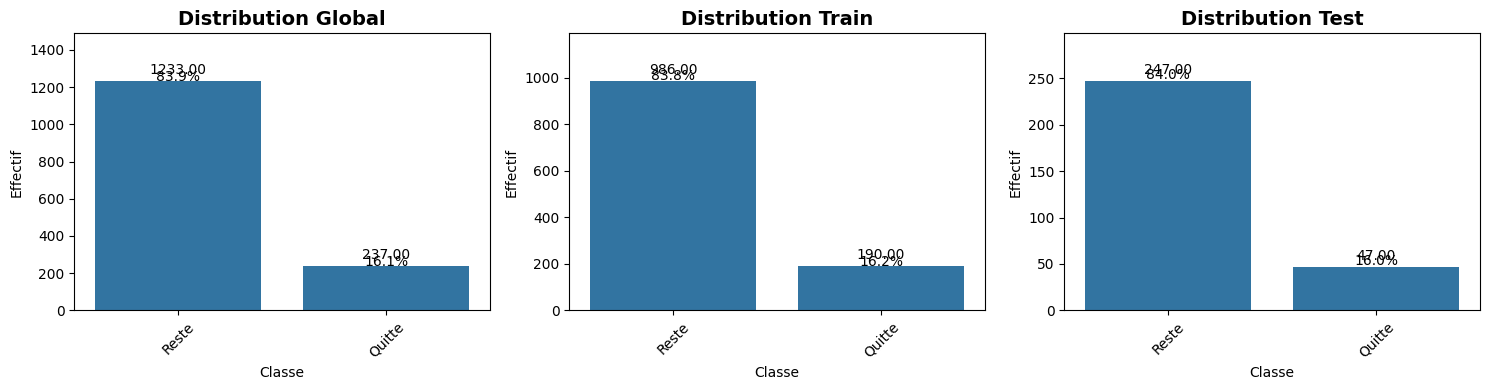

In [4]:
class_labels = {0: 'Reste', 1: 'Quitte'}

print("Distribution globale :")
print(y.value_counts().rename(index=class_labels))
print(f"\nProportion :")
print(y.value_counts(normalize=True).rename(index=class_labels).map(lambda x: f"{x:.1%}"))
print(f"\nRatio déséquilibre : 1 Quitte pour {y.value_counts()[0] / y.value_counts()[1]:.1f} Reste")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (data, title) in zip(axes, [
    (y, "Global"), (y_train, "Train"), (y_test, "Test")
]):
    counts = data.value_counts().rename(index=class_labels)
    df_counts = pd.DataFrame({'Classe': counts.index, 'Effectif': counts.values})
    vi.create_barplot(
        df_counts, ax, x='Classe', y='Effectif',
        title=f'Distribution {title}'
    )
    for i, (label, count) in enumerate(counts.items()):
        pct = count / len(data)
        ax.text(i, count + 2, f"{pct:.1%}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Choix des modèles

L’objectif de ce projet est de prédire si un employé va quitter l’entreprise ou non.  
Il s’agit donc d’un problème de **classification binaire**.

Afin d’évaluer différentes approches, trois modèles ont été entraînés :

- **DummyClassifier** : utilisé comme modèle étalon (baseline), permettant d’établir un niveau minimal de performance. On l'utilise avec la stratégie `most_frequent`, qui consiste à prédire systématiquement la classe majoritaire. Cette approche fournit une baseline simple permettant de vérifier que les modèles entraînés apportent une amélioration significative par rapport à une prédiction naïve.
- **LogisticRegression** : modèle linéaire de classification, choisi pour sa simplicité, sa rapidité et son interprétabilité.
- **RandomForestClassifier** : modèle non-linéaire basé sur des ensembles d’arbres de décision, capable de capturer des relations complexes entre les variables.


In [5]:
pipelines = {
    "Dummy": Pipeline([
        ('preprocessor', preprocessor),
        ('model', DummyClassifier(strategy="most_frequent"))
    ]),
    "LogisticRegression": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ]),
    "RandomForest": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=RANDOM_STATE))
    ])
}

### Choix de la métrique principale

Dans ce projet, l'objectif métier est d'**identifier les employés susceptibles de quitter l'entreprise** afin de permettre aux RH d'agir en amont (entretien, revalorisation, mobilité interne).

**Pourquoi l'accuracy est inadaptée ici :**  
Le jeu de données est fortement déséquilibré (majorité de "Reste"). Un modèle prédisant systématiquement "Reste" obtiendrait une accuracy élevée tout en étant totalement inutile -- il ne détecterait aucun départ.

**Pourquoi le recall sur la classe "Quitte" est prioritaire :**  
- Un **faux négatif** (employé à risque non détecté) = un départ non anticipé, avec un coût élevé pour l'entreprise (recrutement, formation, perte de compétences).  
- Un **faux positif** (fausse alerte) = un entretien RH inutile, dont le coût est faible.  

L'asymétrie des coûts d'erreur justifie de **maximiser le recall** sur la classe "Quitte".

**Le F1-score comme métrique de suivi :**  
Le recall seul pourrait être maximisé en prédisant "Quitte" pour tout le monde. Le F1-score, qui combine precision et recall, permet de s'assurer que le modèle reste utilisable sans générer trop de fausses alertes.

> **Métrique principale retenue : recall sur la classe "Quitte"**, avec le F1-score comme indicateur d'équilibre.

**Note sur les métriques utilisées :**  
Dans les tableaux de résultats ci-dessous, l'**accuracy** est une métrique **globale** (toutes classes confondues), tandis que la **precision**, le **recall** et le **F1-score** sont calculés **uniquement sur la classe "Quitte"** (classe positive = 1). Cette distinction est essentielle : une accuracy de 84% peut masquer un recall de 0% sur la classe d'intérêt, comme le montre le modèle Dummy.

In [6]:
cv = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

# Évaluation sur le jeu de validation
class_names = ['Reste', 'Quitte']

all_cv_results = {}
all_eval_results = {}
for model_name, pipeline in pipelines.items():
    results = md.cross_validate_model(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    all_cv_results[model_name] = results
    eval_results = md.evaluate_model(pipeline, X_train, y_train, X_test, y_test)
    all_eval_results[model_name] = eval_results


df_all_results = md.build_comparison_df(all_cv_results=all_cv_results, all_eval_results=all_eval_results)

display(df_all_results)

,cv_train_accuracy,cv_train_accuracy_std,cv_test_accuracy,cv_test_accuracy_std,cv_train_precision,cv_train_precision_std,cv_test_precision,cv_test_precision_std,cv_train_recall,cv_train_recall_std,...,cv_test_recall_std,cv_train_f1,cv_train_f1_std,cv_test_f1,cv_test_f1_std,cv_time_sec,test_accuracy,test_precision,test_recall,test_f1
model,,,,,,,,,,,,,,,,,,,,,
Dummy,0.838435,0.000069,0.838435,0.000274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,2.209931,0.840136,0.000000,0.000000,0.000000
LogisticRegression,0.902848,0.002911,0.892009,0.018942,0.828668,0.010333,0.779558,0.085765,0.502632,0.017945,...,0.106050,0.625549,0.01507,0.574995,0.097240,2.114953,0.860544,0.615385,0.340426,0.438356
RandomForest,1.000000,0.000000,0.858002,0.014039,1.000000,0.000000,0.742803,0.121876,1.000000,0.000000,...,0.082213,1.000000,0.00000,0.293071,0.112843,1.815268,0.840136,0.500000,0.148936,0.229508


In [7]:
class_names_map = {'0': 'Reste', '1': 'Quitte'}

for model_name, res in all_eval_results.items():
    report = res['report']
    df_report = (
        pd.DataFrame(report)
        .T
        .rename(index=class_names_map)
    )
    # Garder uniquement les lignes pertinentes
    df_report = df_report.loc[
        ['Reste', 'Quitte', 'macro avg', 'weighted avg']
    ]
    df_report['support'] = df_report['support'].astype(int)
    
    print(f"\n{'='*50}")
    print(f"Classification Report - {model_name}")
    print(f"{'='*50}")
    display(df_report)


Classification Report - Dummy


,precision,recall,f1-score,support
Reste,0.840136,1.000000,0.913124,247
Quitte,0.000000,0.000000,0.000000,47
macro avg,0.420068,0.500000,0.456562,294
weighted avg,0.705829,0.840136,0.767148,294



Classification Report - LogisticRegression


,precision,recall,f1-score,support
Reste,0.884328,0.959514,0.920388,247
Quitte,0.615385,0.340426,0.438356,47
macro avg,0.749856,0.649970,0.679372,294
weighted avg,0.841334,0.860544,0.843329,294



Classification Report - RandomForest


,precision,recall,f1-score,support
Reste,0.857143,0.971660,0.910816,247
Quitte,0.500000,0.148936,0.229508,47
macro avg,0.678571,0.560298,0.570162,294
weighted avg,0.800049,0.840136,0.801899,294


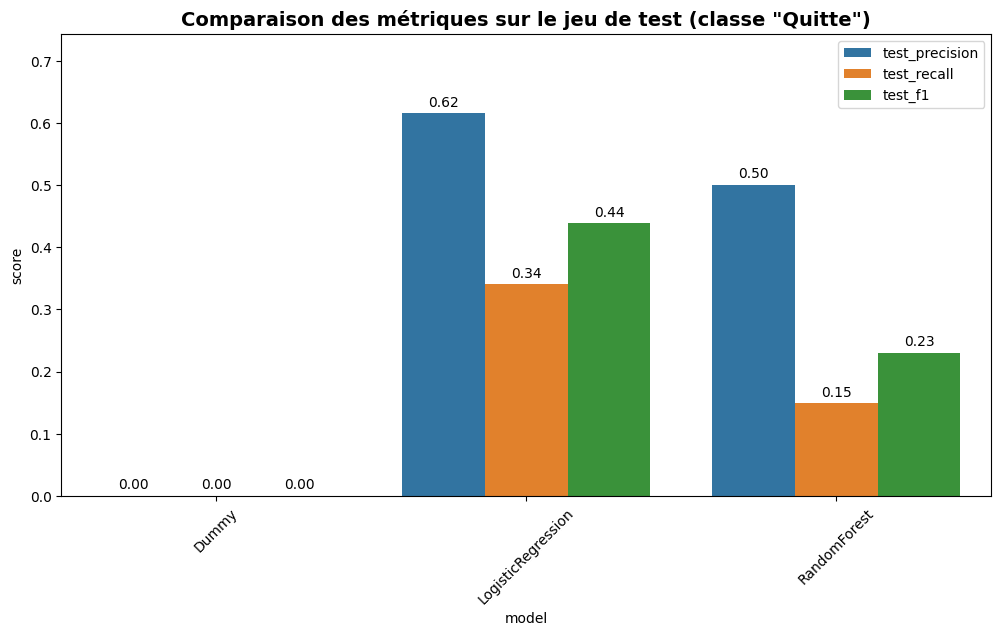

In [8]:
df_metrics = df_all_results[['test_precision', 'test_recall', 'test_f1']].reset_index().melt(
    id_vars='model', var_name='metric', value_name='score'
)
fig, ax = plt.subplots(figsize=(12, 6))
vi.create_barplot(df_metrics, ax, x='model', y='score', hue='metric',
               title='Comparaison des métriques sur le jeu de test (classe "Quitte")')

**Observation**

Les métriques ci-dessus sont calculées **sur la classe "Quitte" uniquement**, ce qui est cohérent avec notre objectif métier de détection des départs.

- Le **Dummy** a un recall et une precision de 0 sur la classe "Quitte" : il est totalement inutile pour notre objectif car il prédit systématiquement "Reste".
- La **LogisticRegression** offre le meilleur équilibre : un recall de ~34% et une precision de ~62% sur la classe "Quitte", ce qui en fait le meilleur modèle à ce stade.
- Le **RandomForest** obtient un recall très faible (~15%) sur la classe "Quitte" : malgré sa complexité, il détecte encore moins de départs que la régression logistique.

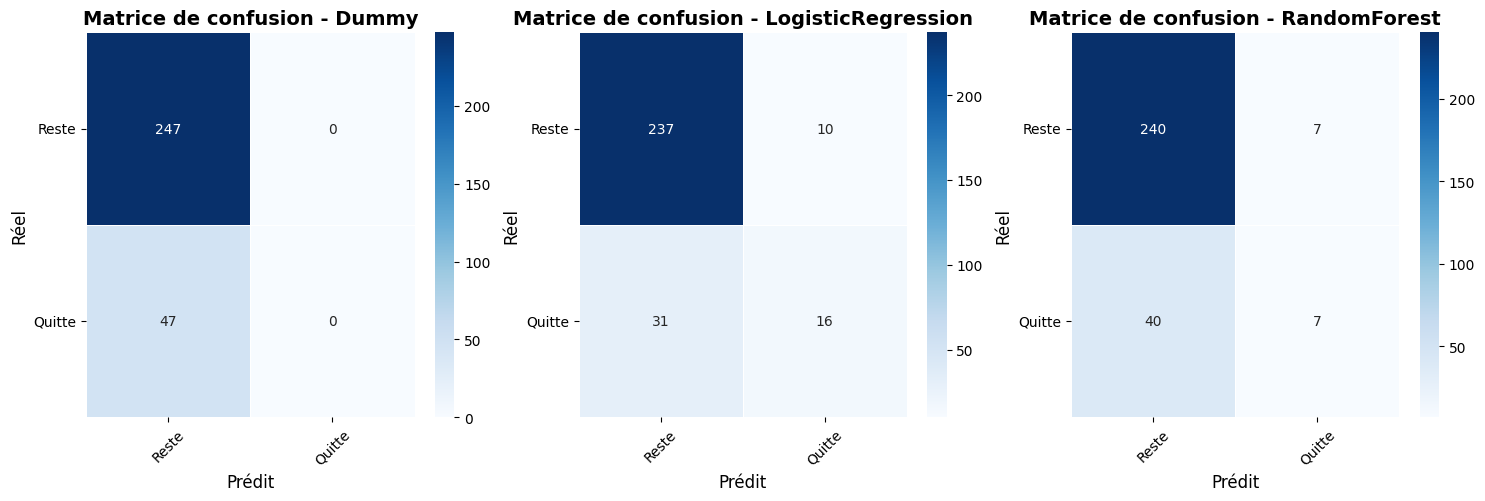

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, res) in zip(axes, all_eval_results.items()):
    cm_df = pd.DataFrame(res['confusion_matrix'], 
                         index=class_names, columns=class_names)
    vi.create_heatmap(cm_df, ax, fmt='d', cmap='Blues',
                   title=f'Matrice de confusion - {name}',
                   xlabel='Prédit', ylabel='Réel')


**Observation**

Ce graphe est le plus parlant.
Le Dummy est inutile pour notre objectif : il ne permet pas d’identifier les employés à risque.
Entre la régression logistique et le Random Forest, la régression logistique fait moins de faux négatifs (elle rate moins de départs), ce qui est essentiel ici.
En RH, mieux vaut une fausse alerte que passer à côté d’un départ.

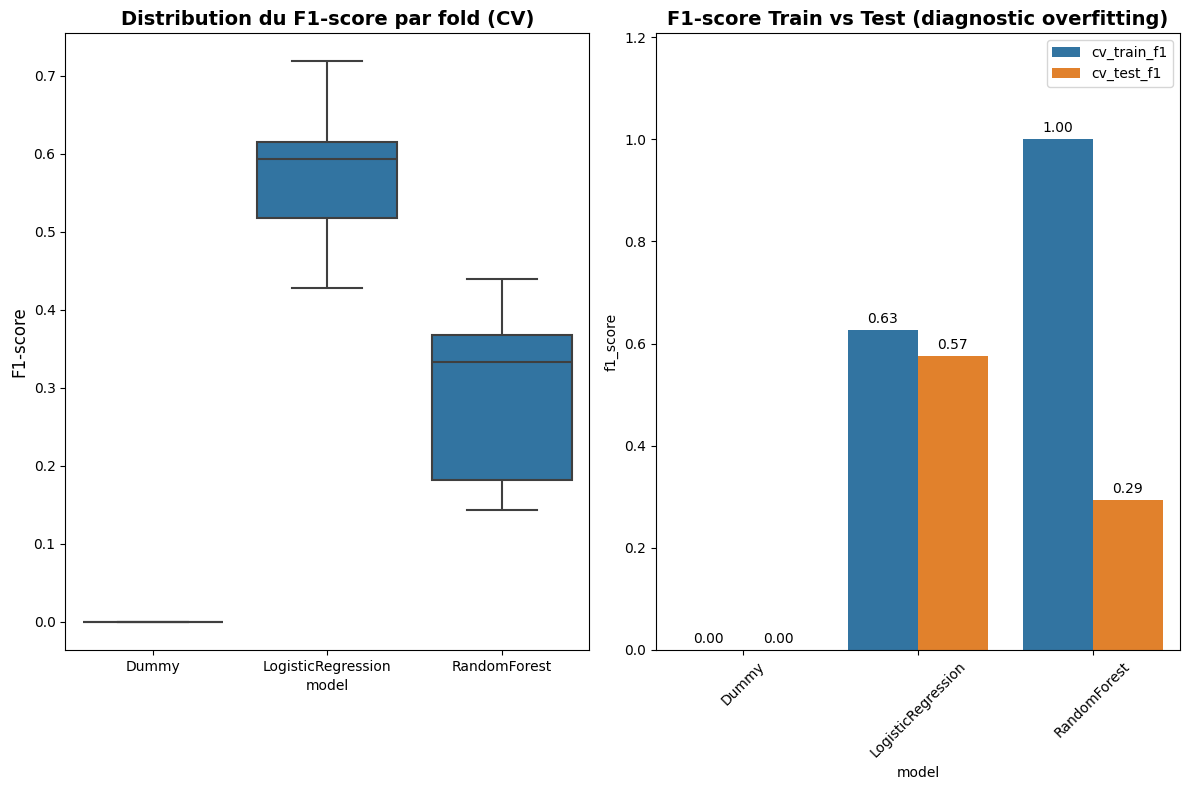

In [10]:
rows = []
for name, res in all_cv_results.items():
    for score in res['cv_results']['test_f1']:
        rows.append({'model': name, 'f1_score': score})
df_cv_folds = pd.DataFrame(rows)

df_overfit = df_all_results[['cv_train_f1', 'cv_test_f1']].reset_index().melt(
    id_vars='model', var_name='set', value_name='f1_score'
)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

vi.create_boxplot(df_cv_folds, ax[0], x='model', y='f1_score',
               title='Distribution du F1-score par fold (CV)', 
               ylabel='F1-score')
vi.create_barplot(df_overfit, ax[1], x='model', y='f1_score', hue='set',
               title='F1-score Train vs Test (diagnostic overfitting)')

plt.tight_layout()
plt.show()


**Observation**

La stabilité de la régression logistique est un avantage majeur : ses performances restent cohérentes entre entraînement et test, ce qui la rend fiable en production.
À l’inverse, le Random Forest est instable : ses scores varient fortement selon les données d’entraînement, signe d’une faible capacité de généralisation. Cette instabilité, combinée à un F1 faible, montre que dans sa configuration par défaut, il n’est pas adapté à ce jeu de données déséquilibré.

Ce graphe met clairement en évidence le surapprentissage : le Random Forest atteint un F1 parfait en entraînement (1.0) mais chute à 0.29 en test, un cas typique d’overfitting sévère.
La régression logistique présente un écart train/test beaucoup plus modéré (~0.06), confirmant sa meilleure généralisation.

Pour rendre le Random Forest compétitif, il faudrait le régulariser (réduire max_depth, augmenter min_samples_leaf) et/ou mieux gérer le déséquilibre des classes (class_weight='balanced').

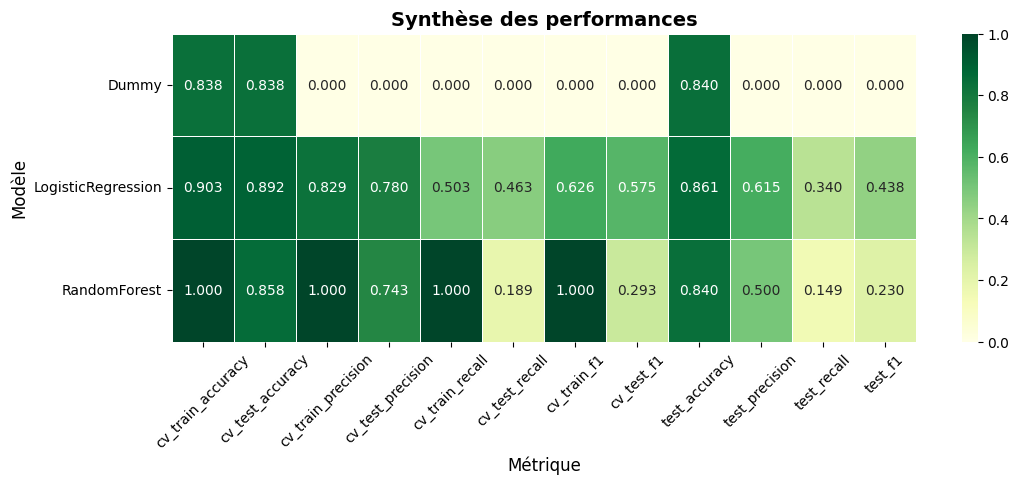

In [11]:
cols_heatmap = [c for c in df_all_results.columns if c != 'cv_time_sec' and '_std' not in c]
fig, ax = plt.subplots(figsize=(12, 4))
vi.create_heatmap(df_all_results[cols_heatmap], ax,
               fmt='.3f', cmap='YlGn', title='Synthèse des performances',
               xlabel='Métrique', ylabel='Modèle')

**Observation**

La heatmap confirme ce qu'on a déjà vu : le Random Forest est excellent en entraînement mais faible en test, signe de surapprentissage.
La régression logistique montre les résultats les plus cohérents entre train et test.

**Conclusion** :

- Le **Dummy** est inutile : toutes ses métriques sur la classe "Quitte" sont à 0.
- La **régression logistique** est le meilleur modèle à ce stade avec les performances les plus cohérentes entre train et test.
- Le **Random Forest** souffre d'un overfitting sévère (F1 train = 1.0, F1 test = 0.23) et devra être régularisé et optimisé dans les prochaines étapes.

### Tableau récapitulatif : performances sur la classe "Quitte"

Ce tableau synthétise les performances des 3 modèles en affichant les métriques de validation croisée (moyenne +/- écart-type) et les métriques sur le jeu de test final, toutes calculées sur la classe "Quitte".

In [12]:
summary_rows = []
for model_name in df_all_results.index:
    row = {'Modèle': model_name}
    for metric in ['recall', 'precision', 'f1']:
        mean = df_all_results.loc[model_name, f'cv_test_{metric}']
        std = df_all_results.loc[model_name, f'cv_test_{metric}_std']
        row[f'CV {metric}'] = f"{mean:.3f} ± {std:.3f}"
        row[f'Test {metric}'] = f"{df_all_results.loc[model_name, f'test_{metric}']:.3f}"
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows).set_index('Modèle')
display(df_summary)

,CV recall,Test recall,CV precision,Test precision,CV f1,Test f1
Modèle,,,,,,
Dummy,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000,0.000 ± 0.000,0.000
LogisticRegression,0.463 ± 0.106,0.340,0.780 ± 0.086,0.615,0.575 ± 0.097,0.438
RandomForest,0.189 ± 0.082,0.149,0.743 ± 0.122,0.500,0.293 ± 0.113,0.230


### Conclusion de l'étape 3

**Modèle baseline retenu : Régression Logistique**

Parmi les trois modèles entraînés, la régression logistique est le meilleur candidat à ce stade :
- Elle surpasse le Dummy sur toutes les métriques de la classe "Quitte" (recall = 34%, F1 = 0.44 sur le test, contre 0% pour le Dummy).
- Elle généralise correctement : l'écart train/test reste modéré, contrairement au Random Forest qui souffre d'un overfitting sévère (F1 train = 1.0, F1 test = 0.23).
- Sa stabilité en validation croisée (faible variance entre les folds) en fait un modèle fiable.

**Limites de cette première modélisation :**
- Le **déséquilibre des classes** n'est pas encore traité (pas de `class_weight`, ni de sur/sous-échantillonnage).
- Les **hyperparamètres** sont ceux par défaut : aucune optimisation n'a été réalisée.
- Le **seuil de classification** est fixé à 0.5 par défaut, sans ajustement au contexte métier.
- Le recall sur la classe "Quitte" reste faible (34%) : le modèle rate encore 2 départs sur 3.

**Prochaines étapes (Étape 4) :**
- Adapter la modélisation au déséquilibre des classes (`class_weight='balanced'`, SMOTE, undersampling).
- Ajuster le seuil de probabilité pour améliorer le recall sans dégrader excessivement la precision.
- Explorer la courbe precision-recall pour trouver le meilleur compromis.
- Régulariser le Random Forest (réduction de `max_depth`, augmentation de `min_samples_leaf`) pour réduire l'overfitting.